In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Setup datasets

In [1]:
import os

def load_captions(captions_folder, images_folder):
    accept_file = os.listdir(captions_folder)
    captions = []
    for filename in os.listdir(images_folder):
        file_txt = filename.split('.')[0] + '.txt'
        if file_txt not in accept_file:
            continue

        with open(os.path.join(captions_folder, file_txt), 'r') as file:
            contents = file.read().split('\n')
            for content in contents:
                captions.append((filename, content))

    return captions

captions = load_captions('./content/cvpr2016_flowers/captions', './content/cvpr2016_flowers/images')

In [2]:
captions = captions[:100]

## Caption Encoder

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel

MAX_LENGTH = 100

# Khởi tạo tokenizer và mô hình DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def encode_captions(captions):
    """
    captions là list các tuple (image_name, caption).
    
    Hàm trả về 1 list chứa các dictionary:
    {
      "image_name": <tên ảnh>,
      "embed": <tensor 768 chiều>,
      "caption": <chuỗi gốc>
    }
    """

    encoded_captions = []
    model.eval() 

    for image_name, caption in captions:
        if caption.strip() != '':
            # 1. Tokenize caption
            inputs = tokenizer(
                caption,
                return_tensors='pt',
                max_length=MAX_LENGTH,
                truncation=True,
                padding='max_length'
            )

            # 2. Chạy qua mô hình để lấy hidden states
            with torch.no_grad():
                outputs = model(**inputs)
                # outputs.last_hidden_state: shape [batch_size=1, seq_len, hidden_size=768]
                sentence_embedding = outputs.last_hidden_state[:,0,:]

            # 4. Bỏ kích thước batch (1) để còn (768,)
            sentence_embedding = sentence_embedding.squeeze(0)  # shape [768]

            # 5. Thêm vào danh sách kết quả
            encoded_captions.append({
                "image_name": image_name,
                "embed": sentence_embedding,
                "caption": caption
            })

    return encoded_captions


encoded_captions = encode_captions(captions)

d:\Asus\Ungdung\Miniconda\workspace\envs\AIOEx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(encoded_captions[10]['embed'].size())

torch.Size([768])


## Preprocessing

In [5]:
from PIL import Image
import os
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, encoded_captions, transform=None):
        """
        img_dir: Thư mục chứa ảnh
        encoded_captions: Danh sách (list) được trả về từ hàm encode_captions,
                          mỗi phần tử có dạng:
                          {
                              "image_name": <tên ảnh>,
                              "embed": <tensor token ids>,
                              "caption": <chuỗi văn bản gốc>
                          }
        transform: Phép biến đổi ảnh (nếu cần)
        """
        self.img_dir = img_dir
        self.transform = transform
        self.encoded_captions = encoded_captions

    def __len__(self):
        return len(self.encoded_captions)

    def __getitem__(self, idx):
        # Lấy ra 1 phần tử tương ứng trong list
        sample = self.encoded_captions[idx]
        image_name = sample["image_name"]
        embed = sample["embed"]        # tensor đã mã hoá bằng tokenizer
        caption = sample["caption"]    # chuỗi gốc

        # Tạo đường dẫn và mở ảnh
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        # Áp dụng transform nếu có
        if self.transform:
            image = self.transform(image)

        # Trả về dưới dạng dictionary
        return {
            "image": image,
            "embed_caption": embed,
            "text": caption
        }

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./content/cvpr2016_flowers/images",
    encoded_captions=encoded_captions,
    transform=transform
)

BATCH_SIZE = 1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
dataloader_iter = iter(dataloader)

# Lấy một batch duy nhất
batch = next(dataloader_iter)

# Kiểm tra các trường bên trong batch
images = batch["image"]
embed_captions = batch["embed_caption"]
captions = batch["text"]

# [batch_size, 3, IMG_SIZE, IMG_SIZE] chẳng hạn
print("Kích thước ảnh:", images.shape)
print("Kích thước embed:", embed_captions.shape if hasattr(
    embed_captions, 'shape') else type(embed_captions))
print("Caption mẫu 0:", captions[0])

Kích thước ảnh: torch.Size([91, 3, 128, 128])
Kích thước embed: torch.Size([91, 768])
Caption mẫu 0: this flower has flat elongated creamy petals around a fringe of purple white and brown petals and large stamen.


## Model

### Generator

In [8]:
import torch.nn as nn
import torch

class Generator(nn.Module):
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduce_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduce_dim_size
        self.noise_size = noise_size
        # 768 --> 256
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size,
                      out_features=reduce_dim_size),
            nn.BatchNorm1d(num_features=reduce_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.upsamplingBlock = nn.Sequential(
            # 256 + 100 --> 1024
            # (inchannels, outchannels, kernel_size, stride, padding, bias)
            # h, w = (1−1)×1+4=4 
            nn.ConvTranspose2d(noise_size + reduce_dim_size,
                               feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # 1024 --> 512
            # h, w = (4−1)×2−2+4=8
            nn.ConvTranspose2d(
                feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # 512 --> 256
            # h, w = (8−1)×2−2+4=16
            nn.ConvTranspose2d(
                feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # 256 --> 128
            # h, w = (16−1)×2−2+4=32
            nn.ConvTranspose2d(
                feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 128
            # h, w = (32−1)×2−2+4=64
            nn.ConvTranspose2d(feature_size, feature_size,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # 128 --> 3
            # h, w = (64−1)×2−2+4=128
            nn.ConvTranspose2d(feature_size, num_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        concat_input = torch.cat(
            [noise, encoded_text], dim=1).view(-1, self.noise_size + self.reduced_dim_size, 1, 1)
        print(concat_input.size())
        output = self.upsamplingBlock(concat_input)
        return output

#### Test generator

In [33]:
real_image = batch["image"][0: 2]        
text_embed = batch["embed_caption"][0: 2]     
raw_text = batch["text"][0]                  

print("real_image shape:", real_image.shape)
print("text_embed shape:", text_embed.shape)
print("Caption (chuỗi gốc):", raw_text)

noise_size = 100  
noise = torch.randn(2, noise_size)

generator = Generator(100, 128, 3, 768, 256)
fake_image = generator(noise, text_embed)

print("fake_image shape:", fake_image.shape)
# # Thông thường sẽ là [1, num_channels, height, width]

real_image shape: torch.Size([2, 3, 128, 128])
text_embed shape: torch.Size([2, 768])
Caption (chuỗi gốc): this flower has flat elongated creamy petals around a fringe of purple white and brown petals and large stamen.
torch.Size([2, 356, 1, 1])
fake_image shape: torch.Size([2, 3, 128, 128])


## Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, feature_size, embedding_size, reduce_dim_size):
        super(Discriminator, self).__init__()
        self.imageEncoder = nn.Sequential(
            # 3 --> 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 --> 128
            nn.Conv2d(feature_size, feature_size , 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 --> 256
            nn.Conv2d(feature_size , feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 --> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 --> 1028
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size,
                      out_features=reduce_dim_size),
            nn.BatchNorm1d(num_features=reduce_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Conv2d((feature_size * 8) + reduce_dim_size,
                      1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        image_features = self.imageEncoder(image)
        
        # Reshape text embedding
        encoded_text = encoded_text.unsqueeze(0).unsqueeze(0)  # thêm 2 chiều mới -> shape: [1, 1, 2, 768]
        encoded_text = encoded_text.repeat(4, 4, 1, 1)         # lặp lại -> shape: [4, 4, 2, 768]
        encoded_text = encoded_text.permute(2, 3, 0, 1)        # hoán đổi chiều -> shape: [2, 768, 4, 4]

        print("encoded_text size:", encoded_text.size())
        print("image_features size:", image_features.size())
        concat_input = torch.cat([image_features, encoded_text], dim=1)
        output = self.classifier(concat_input)

        return output

#### Test Discriminator

In [31]:
real_image = batch["image"][0: 2]
text_embed = batch["embed_caption"][0: 2]
raw_text = batch["text"][0]

print("real_image shape:", real_image.shape)
print("text_embed shape:", text_embed.shape)
print("Caption (chuỗi gốc):", raw_text)

discriminator = Discriminator(3, 128, 768, 256).to(device)
classifier = discriminator(fake_image, text_embed)

print(classifier)

real_image shape: torch.Size([2, 3, 128, 128])
text_embed shape: torch.Size([2, 768])
Caption (chuỗi gốc): this flower has flat elongated creamy petals around a fringe of purple white and brown petals and large stamen.
encoded_text size: torch.Size([2, 256, 4, 4])
image_features size: torch.Size([2, 1024, 4, 4])
tensor([[[[0.5297]]],


        [[[0.4201]]]], grad_fn=<SigmoidBackward0>)


## Trainning

### Plot image

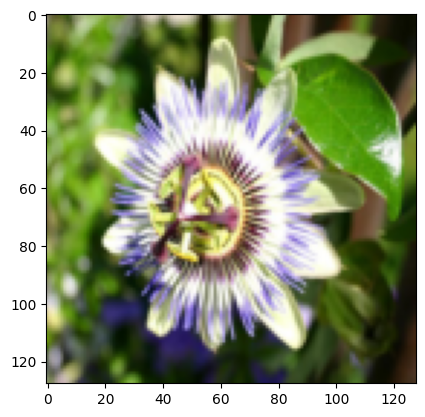

torch.Size([1, 100])
torch.Size([1, 768])
torch.Size([1, 356, 1, 1])


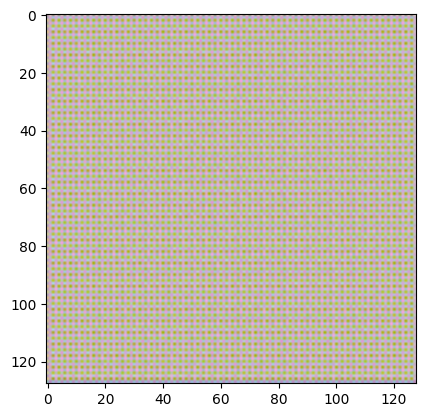

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


noise_size = 100
fixed_noise = torch.randn(size=(1, noise_size))
plt_o_text_embeddings = batch['embed_caption'][0].unsqueeze(0)
show_grid(torchvision.utils.make_grid(ds[0]["image"], normalize=True))

def plot_output(generator):
    plt.clf()
    with torch.no_grad():
        generator.eval()
        test_images = generator(fixed_noise.to(
            device), plt_o_text_embeddings.to(device))
        generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

plot_output(generator)

### Trainning

In [ ]:
import torch.optim as optim

generator = Generator(100, 128, 3, 768, 256).to(device)
discriminator = Discriminator(3, 128, 768, 256).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(),
                         lr=0.0002, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
import time

epochs = 500

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        # 1. Chuẩn bị dữ liệu
        real_images = batch["image"].to(device)
        text_embeddings = batch["embed_caption"].to(device)

        # 2. Tạo các nhãn
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        # 3. Huấn luyện Discriminator
        optimizer_D.zero_grad()
        fake_images = generator(torch.randn(
            real_images.size(0), noise_size).to(device), text_embeddings)
        pred_fake = discriminator(fake_images, text_embeddings)
        loss_fake = bce_loss(pred_fake, fake_labels)

        pred_real = discriminator(real_images, text_embeddings)
        loss_real = bce_loss(pred_real, real_labels)

        loss_discriminator = (loss_fake + loss_real) / 2
        d_losses += [loss_discriminator.item()]
        loss_discriminator.backward()
        optimizer_D.step()

        # 4. Huấn luyện Generator
        optimizer_G.zero_grad()
        fake_images = generator(torch.randn(
            real_images.size(0), noise_size).to(device), text_embeddings)
        pred_fake = discriminator(fake_images, text_embeddings)
        loss_generator = bce_loss(pred_fake, real_labels) + \
            l1_loss(fake_images, real_images) # pixelwise loss
        g_losses += [loss_generator.item()]
        loss_generator.backward()
        optimizer_G.step()

        
    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    if (epoch+1) % 10 == 0:
        plot_output(generator)


    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

## Inferences

In [ ]:
generator.eval()
caption = "this pale pink flower has a large yellow and green pistil."
embed_caption = torch.tensor(bert_model.encode(caption))
noise = torch.randn(size=(1, 100))
text_embedding = embed_caption.unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))

grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)